# DSCI552: HW7
#Part 2: CNN For Image Colorization


***Name: Cheng Peng***


***USC ID: 6898-9638-37***

In [ ]:
import os 
import tensorflow as tf 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import to_categorical
import string
import numpy as np
from sklearn.cluster import KMeans
from skimage.color import rgb2gray
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from scipy.spatial import distance
from tensorflow.keras.callbacks import Callback

# A): Download CIFAR-10 data 

In [ ]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
print("There are {} images in training set and {} in test set".format(len(train_x), len(test_x)))

There are 50000 images in training set and 10000 in test set


# B): Extract calss bird 

In [ ]:
train_x = train_x[np.where(train_y == 2)[0]]
test_x = test_x[np.where(test_y==2)[0]]

In [ ]:
print("There are {} bird images in the training set and {} bird images in the test set ".format(len(train_x), len(test_x)))

There are 5000 bird images in the training set and 1000 bird images in the test set 


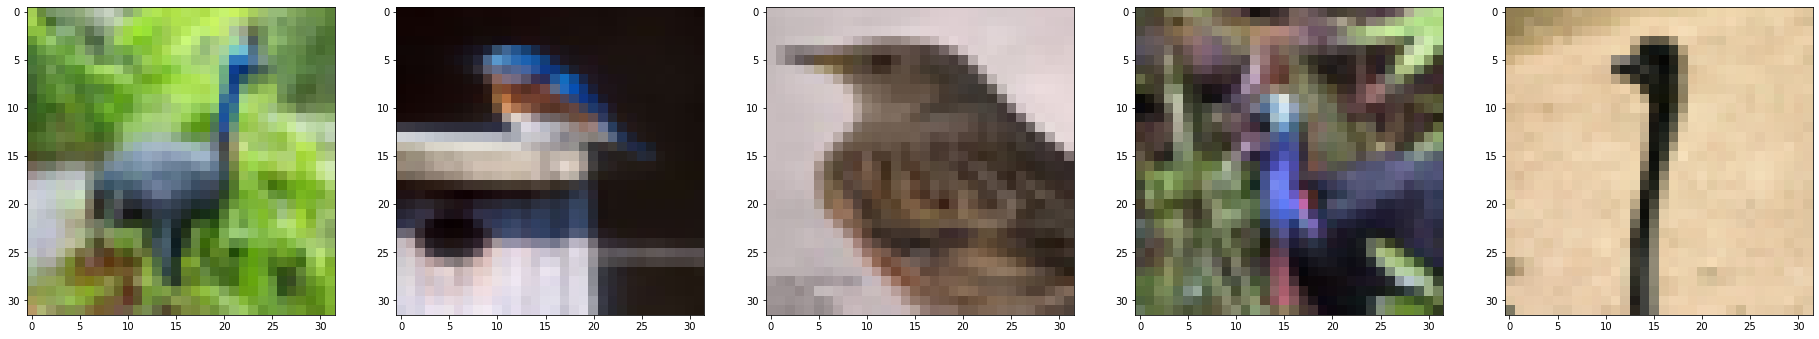

In [ ]:
f, axis = plt.subplots(1, 5, figsize=(32,32))
for i in range(5):
    axis[i].imshow(train_x[i])

# C): Choose some pixels 

In [ ]:
# use all the piels of all images 
x = np.concatenate((train_x, test_x))
pixels = x.reshape((-1, 3))

# D): Run K-mean to determine the center of clusters, and convert RGB colors to 4 color bins 

In [ ]:
model = KMeans(n_clusters=4).fit(pixels)

In [ ]:
centers = model.cluster_centers_
print("The cluster ceners are {}".format(centers))

The cluster ceners are [[107.80451343 107.5297899   81.84766413]
 [205.60884919 210.89673056 210.50661094]
 [ 48.36064983  49.34747247  38.06455339]
 [155.37981849 154.52840493 133.96643553]]


In [ ]:
# since RGB values should be integers, round the cluster center values 
centers = centers.astype('int')

In [ ]:
# map all pixels to the cloest center 
color_dict = {0:centers[0], 1:centers[1], 2:centers[2], 3:centers[3]}
converted_pixel = [color_dict[i] for i in model.labels_]

In [ ]:
converted_pixel = np.reshape(converted_pixel, (6000, 32, 32, 3))

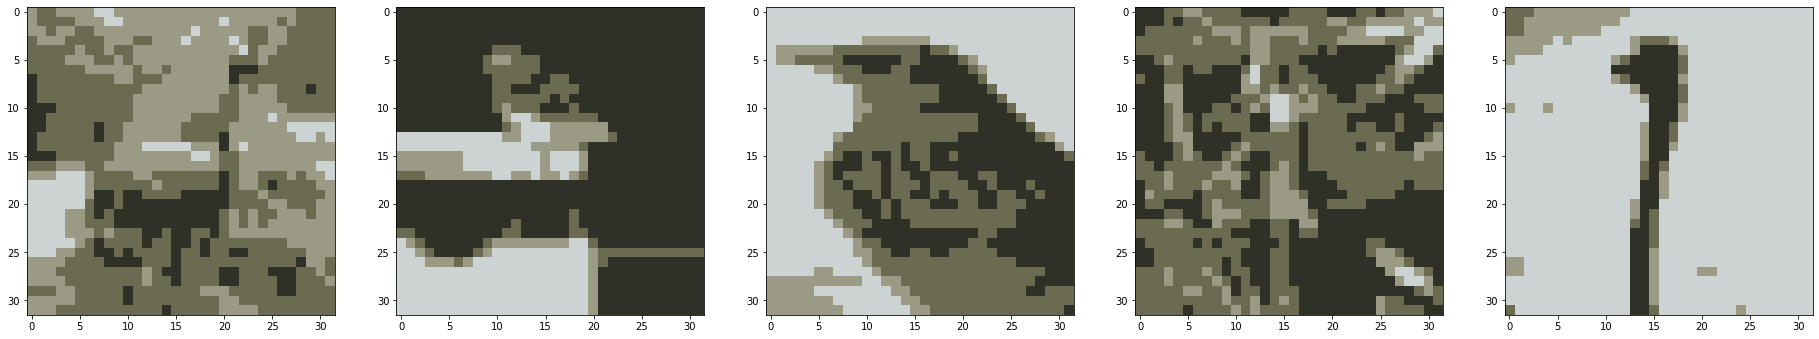

In [ ]:
f, axis = plt.subplots(1, 5, figsize=(32,32))
for i in range(5):
    axis[i].imshow(converted_pixel[i])

In [ ]:
# since the converted pixel colors are not exactly "colorful", we use another set of colors 
color_alter = [[0, 0, 128], [230, 25, 75], [170, 255, 195], [255, 255, 255]]
# calculate which color is the pixel closest to 
def closestColor(rgb_color, color_alter):
    dis = []
    for i in color_alter:
        dis.append(distance.euclidean(rgb_color, i))
    return np.argmin(dis)


In [ ]:
converted_pixel_alter = [color_alter[closestColor(pixel, color_alter)] for pixel in pixels]

In [ ]:
converted_pixel_alter = np.reshape(converted_pixel_alter, (6000, 32, 32, 3))

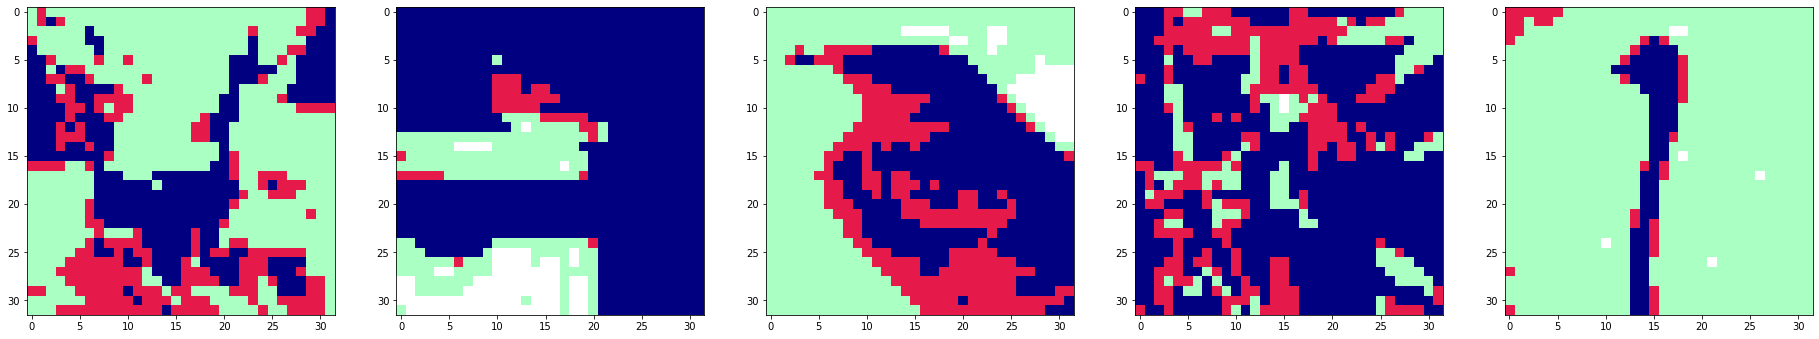

In [ ]:
f, axis = plt.subplots(1, 5, figsize=(32,32))
for i in range(5):
    axis[i].imshow(converted_pixel_alter[i])

# E): Convert colored images to grayscale images 

In [ ]:
x_gray = [rgb2gray(image) for image in x.reshape((6000,32,32,3))]
x_gray = np.reshape(x_gray, (6000, 32, 32))

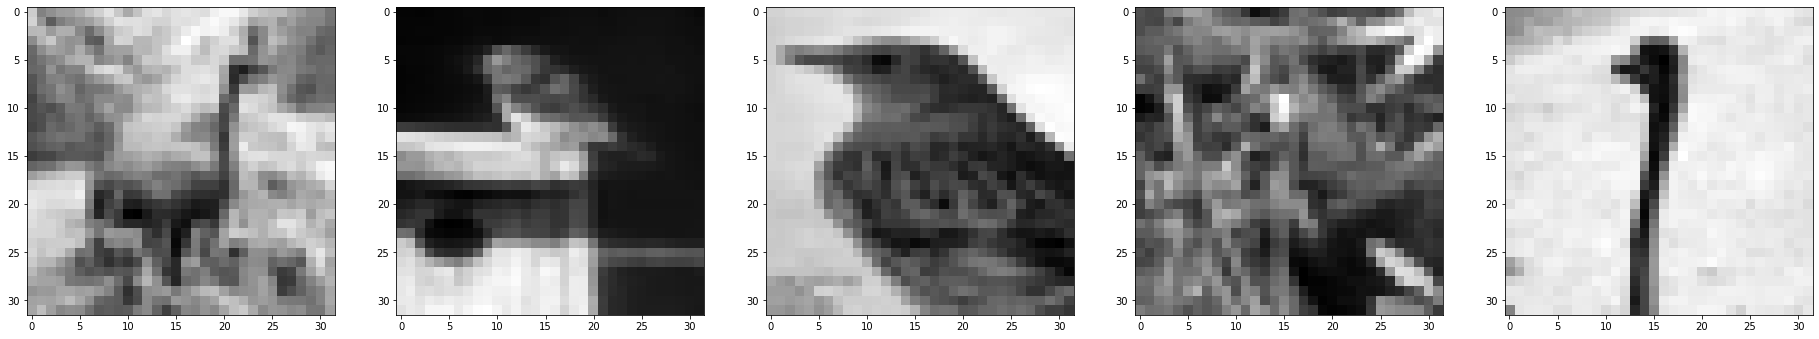

In [ ]:
f, axis = plt.subplots(1, 5, figsize=(32,32))
for i in range(5):
    axis[i].imshow(x_gray[i], cmap = plt.cm.gray)

# F): CNN 

***Comment:***I am going to use the 4 colors given in the handout as color bins for clorization 

In [ ]:
color_alter = [[0, 0, 128], [230, 25, 75], [170, 255, 195], [255, 255, 255]]
x = np.concatenate((train_x, test_x)).reshape((-1,3))

In [ ]:
converted_pixel_alter = [closestColor(pixel, color_alter) for pixel in x]

In [ ]:
# convert to one-hot encoding 
pixel_color_bin = to_categorical(converted_pixel_alter, num_classes=4)

In [ ]:
pixel_color_bin = pixel_color_bin.reshape((6000, 32, 32, -1))

In [ ]:
print("The shape of the output is {}".format(pixel_color_bin.shape))

The shape of the output is (6000, 32, 32, 4)


In [ ]:
# prepare the input and output data 
x_gray = x_gray.reshape((6000,32,32, 1))
pixel_color_bin = pixel_color_bin.reshape((6000,32,32,4))

In [ ]:
# split into training validation and test datasets 
train_x, train_y = x_gray[:5000], pixel_color_bin[:5000]
test_x, test_y = x_gray[5000:], pixel_color_bin[5000:]

In [ ]:
print("Training set: {} images \nTest set: {} images".format(len(train_x), len(test_x)))

Training set: 5000 images 
Test set: 1000 images


In [ ]:
def getModel():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='same', input_shape=(32,32,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2), padding = 'same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(Dropout(0.2))

    # MLP 
    model.add(Flatten())
    model.add(Dense(8192, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Reshape((32,32,4)))
    model.add(Activation('softmax'))
    return model 

In [ ]:
model = getModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [ ]:
model_file = "colorization-epoch-{epoch:02d}-loss-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(model_file, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
# to speed up the training, i set the runtime to GPU and train the model in GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
results = model.fit(x = train_x, y = train_y, validation_data=(test_x, test_y), verbose = 1, epochs=30, batch_size=128, callbacks=[checkpoint])

Epoch 1/30
39/40 [============================>.] - ETA: 0s - loss: 1.2247 - accuracy: 0.4873
Epoch 00001: loss improved from 1.25887 to 1.22477, saving model to colorization-epoch-01-loss-1.2248.hdf5
40/40 [==============================] - 4s 99ms/step - loss: 1.2248 - accuracy: 0.4873 - val_loss: 1.1738 - val_accuracy: 0.5337
Epoch 2/30
39/40 [============================>.] - ETA: 0s - loss: 1.1033 - accuracy: 0.5560
Epoch 00002: loss improved from 1.22477 to 1.10338, saving model to colorization-epoch-02-loss-1.1034.hdf5
40/40 [==============================] - 5s 113ms/step - loss: 1.1034 - accuracy: 0.5560 - val_loss: 1.1818 - val_accuracy: 0.5040
Epoch 3/30
39/40 [============================>.] - ETA: 0s - loss: 1.0561 - accuracy: 0.5767
Epoch 00003: loss improved from 1.10338 to 1.05611, saving model to colorization-epoch-03-loss-1.0561.hdf5
40/40 [==============================] - 21s 521ms/step - loss: 1.0561 - accuracy: 0.5767 - val_loss: 1.0200 - val_accuracy: 0.5975
Epoc

***Comment:*** Even thought it prints "val_accuracy" and "val_loss", they are calculated over the test set which has 1000 images. 

I am assuming we can use test/validation sets interchangeably since the handout states "Plot training,(validation), and test errors ***in each epoch***". 

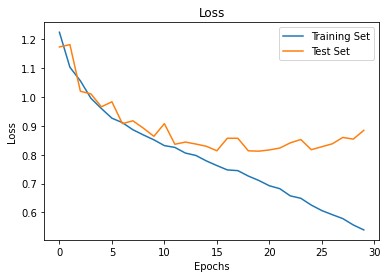

In [ ]:
plt.plot(list(range(30)), results.history["loss"], label = "Training Set")
plt.plot(list(range(30)), results.history["val_loss"], label = "Test Set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.title("Loss")
plt.show()

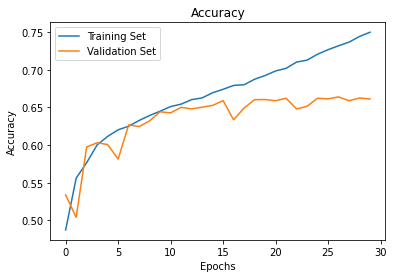

In [ ]:
plt.plot(list(range(30)), results.history["accuracy"], label = "Training Set")
plt.plot(list(range(30)), results.history["val_accuracy"], label = "Validation Set")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Accuracy")
plt.show()

In [ ]:
 # determine the lowest validation loss 
 print("The epoch with the lowest test/validation loss is {}".format(np.argmin(results.history["val_loss"])+1))

The epoch with the lowest test/validation loss is 20


***Comment:*** The model becomes overfit around 20th epoch as the training loss continues to decrease and test/validation loss slightly increases. I will load the weights of the 15th epoch to evaluate the test set. 

In [ ]:
optimal_model_path = "/content/colorization-epoch-20-loss-0.7108.hdf5"
optimal_model = getModel()
optimal_model = load_model(optimal_model_path)

In [ ]:
train_results = optimal_model.evaluate(train_x, train_y)
test_results = optimal_model.evaluate(test_x, test_y)

32/32 [==============================] - 0s 3ms/step - loss: 0.8124 - accuracy: 0.6606


In [ ]:
print("The optimal Model:\nTrainning loss = {:.4f}, training accuracy = {:.4f}\nTest loss = {:.4f}, test loss = {:.4f}".format(train_results[0], train_results[1], test_results[0], test_results[1]))

The optimal Model:
Trainning loss = 0.6720, training accuracy = 0.7077
Test loss = 0.8124, test loss = 0.6606


In [ ]:
#test the model on images that it has never seen before 
# I use the first 10 images in the test set 
x = x.reshape((6000, 32, 32, 3))
original_image = x[:10]
gray = test_x[:10]
ground_truth = test_y[:10]
predict = optimal_model.predict(gray)

In [ ]:
# convert the color bins to  RGB color vectors
predict = predict.reshape((-1, 4))
predict_color_bin = [np.argmax(x) for x in predict]
predict_color_bin = [color_alter[color_bin] for color_bin in predict_color_bin]
predict_colored = np.reshape(predict_color_bin,(10,32,32,-1))

ground_truth = ground_truth.reshape((-1,4))
ground_truth_color_bin = [np.argmax(x) for x in ground_truth]
ground_truth_color_bin = [color_alter[color_bin] for color_bin in ground_truth_color_bin]
ground_truth_colored = np.reshape(ground_truth_color_bin, (10,32,32,-1))

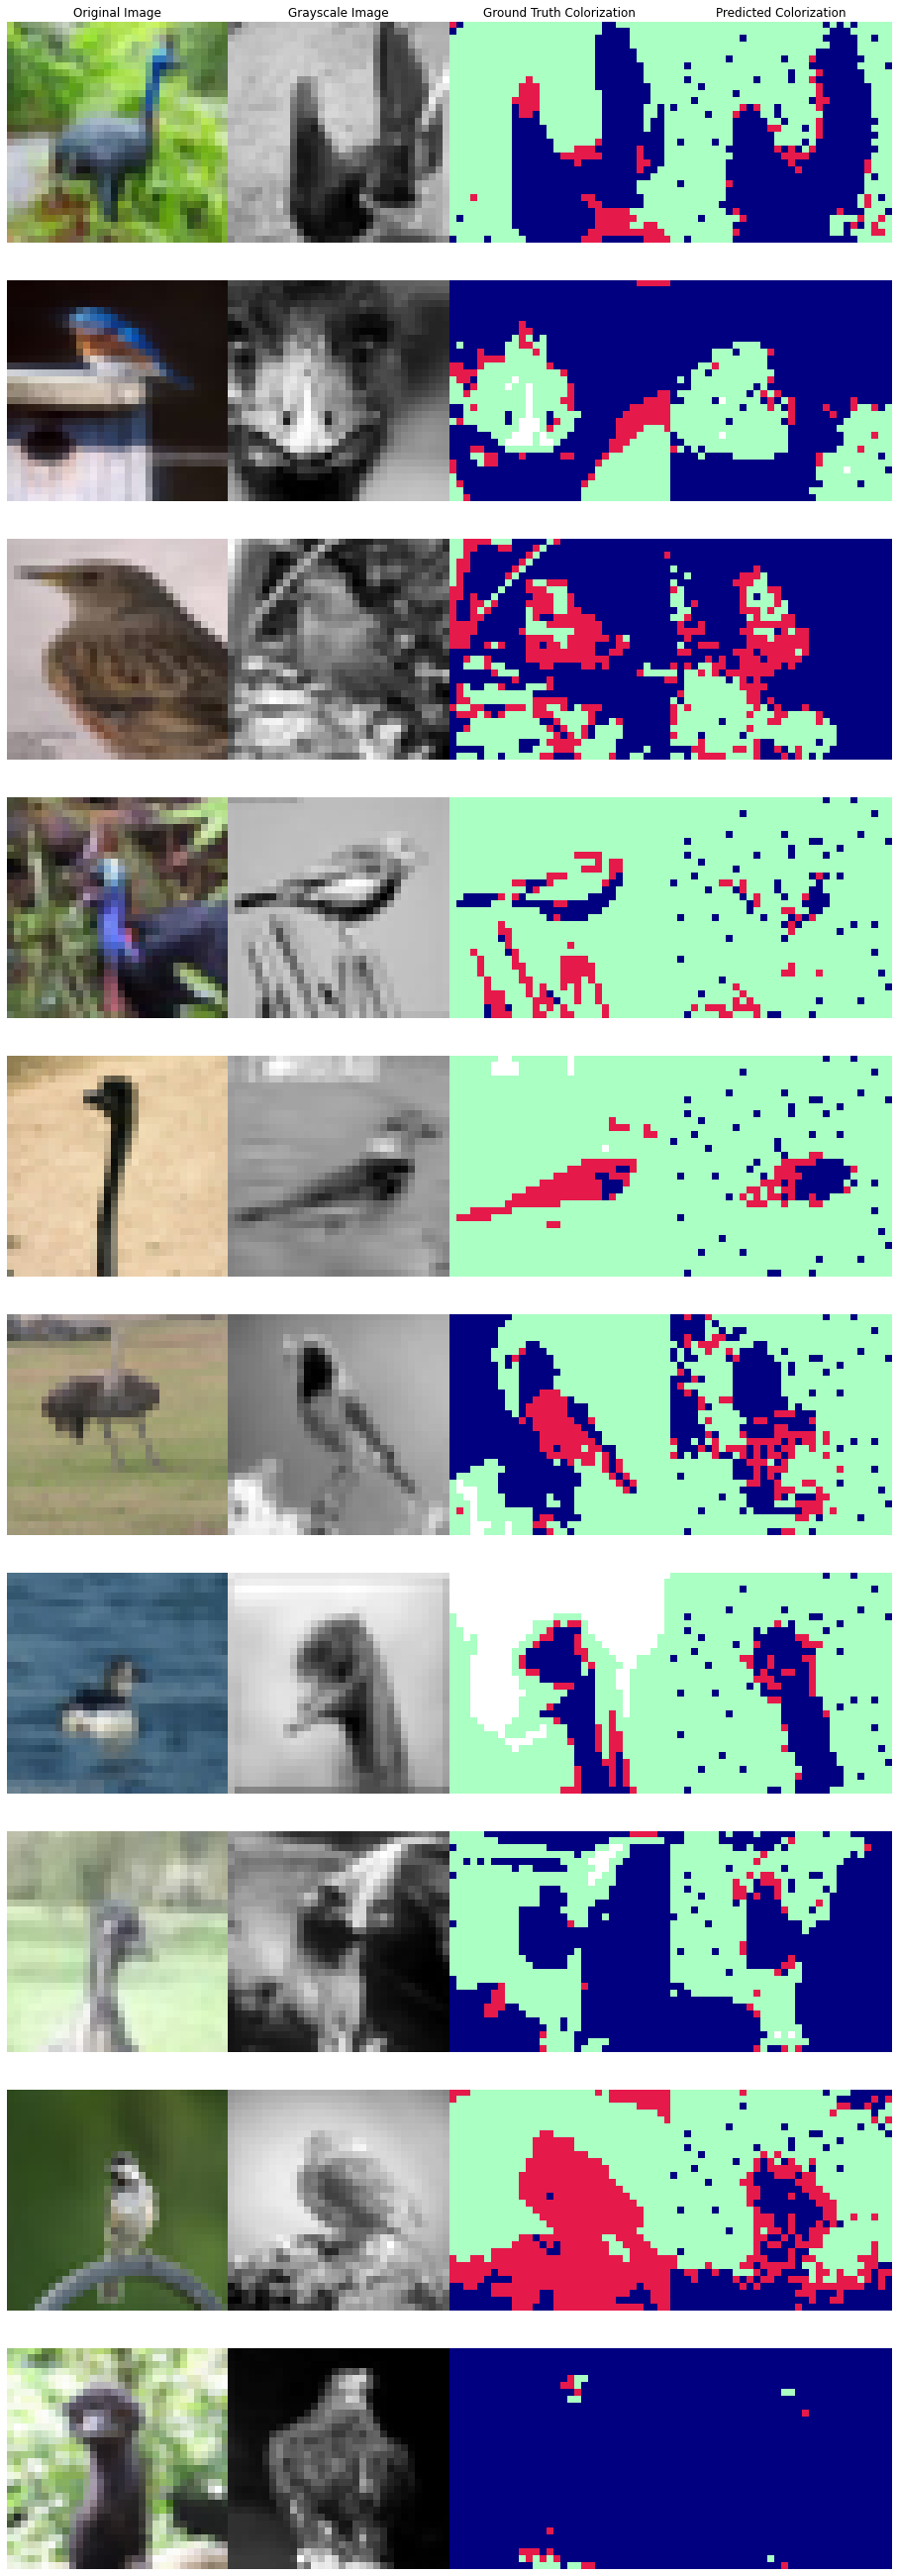

In [ ]:
# use the model to plot images 
fig, axes = plt.subplots(10,4, figsize = (16,48))
for i in range(10):
    axes[i][0].imshow(original_image[i])
    axes[i][0].axis('off')
    axes[i][1].imshow(gray[i].reshape((32,32)), cmap = plt.cm.gray)
    axes[i][1].axis('off')
    axes[i][2].imshow(ground_truth_colored[i])
    axes[i][2].axis('off')
    axes[i][3].imshow(predict_colored[i])
    axes[i][3].axis('off')

axes[0][0].set_title("Original Image")
axes[0][1].set_title("Grayscale Image")
axes[0][2].set_title("Ground Truth Colorization")
axes[0][3].set_title("Predicted Colorization")

plt.subplots_adjust(wspace=0, hspace=0)


***Comment:*** the images are, from the left to right, the original images,  gray scale input to the model, the ground truth colorization image using the four color given in the handout and the output colored image produced by the model respectively. 


*   the model can learn some features of the images and predicts color correcdtly, for instance, the blue sky and grass. 
* the model is able to capture the bird in the images and distingush it from the background. 
*   the model is limited to the number of color bins. we are only using 4 color bins thus the model cannot predict color beyoind that. 




# Reference: 


1.   https://www.tensorflow.org/tutorials/images/cnn

